In [1]:
import pickle
import numpy as np
import cv2
import librosa
from fcwt import *
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.io import wavfile
import os
from numpy.random import RandomState
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, AddGaussianSNR

In [2]:
print(fcwt.Superlet)

<class 'fcwt.fcwt.Superlet'>


In [3]:
import create_TF_images as TF
import data_augmentation as DA

/Users/6884407/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import

In [21]:
index = 100 #CHOOSE INDEX

# BOTH EMODB AND ENTERFACE
sl = 3 #signal length in seconds
size = (227,227)

########## EMODB ###########
Fs, audio_raw, labels, subject_label = TF.preprocess_emodb()
float_audio = TF.pcm2float(audio_raw)

signal_edb = float_audio[index]


########### E05 ###########
ent_audio = np.load("enterface05_audio_wo-subject6.pkl", allow_pickle=True)
# ent_labels = np.load("enterface05_label.npy", allow_pickle=True)

signal_e05 = ent_audio[index]


/Users/6884407/pr-dlass-2/create_TF_images.py:279: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read("%s/%s" % (directory, audio_file))


LINUX PATH
SAMPLING RATE = 16000 Hz


### Visualize noise

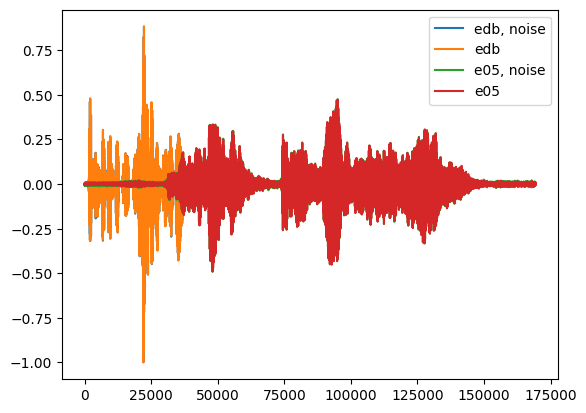

In [22]:
snr = 30                                                                                        

add_SNR = AddGaussianSNR(
    min_snr_in_db=snr,
    max_snr_in_db=snr,
    p=1.0                       
) 

# noise = 0.005

# add_noise = AddGaussianNoise(                       
#     min_amplitude=noise,
#     max_amplitude=noise,
#     p=1.0
# )

plt.plot(add_SNR(signal_edb, sample_rate=16000), label='edb, noise')
plt.plot(signal_edb, label='edb')
plt.plot(add_SNR(signal_e05, sample_rate=44100), label='e05, noise')
plt.plot(signal_e05, label='e05')
plt.legend()
plt.show()

In [13]:
########### CHOOSE SIGNAL ###########

edb = True # CHANGE THIS TO FALSE FOR E05

if(edb):    
    Fs = 16000
    f1 = 8000
    signal = signal_edb
    signal = add_SNR(signal, sample_rate=16000)
else:
    Fs = 44100
    f1 = 9785
    signal = signal_e05
    signal = add_SNR(signal_e05, sample_rate=16000)

# np.save('signal.txt',signal)

/Users/6884407/opt/miniconda3/lib/python3.9/site-packages/audiomentations/core/transforms_interface.py:57: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


# fCWT examples

[[2.8065329e+01 1.5632753e+01 4.0340359e+01 ... 9.3934858e-01
  9.4078702e-01 9.4255733e-01]
 [2.7867733e+01 2.6484556e+01 4.2953186e+01 ... 8.2586700e-01
  8.3982623e-01 8.3746105e-01]
 [2.6349106e+01 3.6664307e+01 4.3738907e+01 ... 6.8889761e-01
  6.7872673e-01 6.9106275e-01]
 ...
 [6.0448956e+00 6.1467113e+00 6.1927805e+00 ... 2.6280112e-03
  2.6633511e-03 2.7094532e-03]
 [4.7278628e+00 1.6086521e+00 4.9421096e+00 ... 9.0051085e-01
  9.1561031e-01 9.1412807e-01]
 [4.0916033e+00 2.2759185e+00 4.7039232e+00 ... 9.1179833e-02
  2.8477457e-01 5.9365743e-01]]
[[-54.857834 -59.940525 -51.70644  ... -80.00001  -80.00001  -80.00001 ]
 [-54.919205 -55.36138  -51.161327 ... -80.00001  -80.00001  -80.00001 ]
 [-55.40592  -52.53637  -51.003876 ... -80.00001  -80.00001  -80.00001 ]
 ...
 [-68.19346  -68.04838  -67.98352  ... -80.00001  -80.00001  -80.00001 ]
 [-70.32794  -79.69199  -69.942986 ... -80.00001  -80.00001  -80.00001 ]
 [-71.58337  -76.6781   -70.37203  ... -80.00001  -80.00001  -80.0

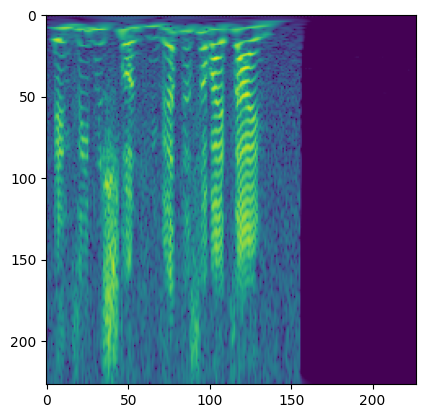

In [24]:
f0 = 1
fn = 227

signal_len = 3

nb_samples = int(signal_len * Fs)
if len(signal) < nb_samples:
    signal = np.pad(signal, (0, nb_samples - len(signal)), 'constant')

#############################################

sigma = 10

#############################################

out = np.zeros((fn, len(signal)), dtype='csingle')
freqs = np.zeros((fn), dtype='single')

#############################################

wavelet = fcwt.Morlet(sigma)
# wavelet = fcwt.Superlet(1, 20, 10)

#############################################

scales = fcwt.Scales(wavelet, FCWT_LINFREQS, Fs, f0, f1, fn)
scales.getFrequencies(freqs)
fcwt_gen = FCWT(wavelet, 8, True, False)
fcwt_gen.cwt(np.array(signal, dtype='float32'), scales, out)

#############################################

# crop
chopped_fcwt = np.absolute(out[:, 0:Fs * signal_len])
resized_fcwt = cv2.resize(chopped_fcwt, dsize=(227, 227), interpolation=cv2.INTER_CUBIC)
print(resized_fcwt)
fcwt_db = librosa.amplitude_to_db(resized_fcwt, ref=np.max)
print(fcwt_db)
fcwt_db = np.flipud(fcwt_db)
print(fcwt_db)
plt.imshow(fcwt_db)


[[-74.40231  -74.35432  -74.30727  ... -80.       -80.       -80.      ]
 [-74.40231  -74.35432  -74.30727  ... -80.       -80.       -80.      ]
 [-60.13372  -60.106827 -60.080704 ... -64.932465 -64.86411  -64.79525 ]
 ...
 [-48.421738 -45.655388 -48.855534 ... -80.       -80.       -80.      ]
 [-47.097927 -50.489017 -61.83644  ... -80.       -80.       -80.      ]
 [-42.608932 -46.892166 -54.62702  ... -80.       -80.       -80.      ]]


# FCWT different sigmas

### fCWT for different sigmas

In [15]:
outputs = []

sigmas = np.geomspace(0.2,100,5)
# sigmas = np.array([2.,26.,50.])


nb_samples = int(signal_len * Fs)
if len(signal) < nb_samples:
    signal = np.pad(signal, (0, nb_samples - len(signal)), 'constant')

for sigma in sigmas:
    out = np.zeros((fn, len(signal)), dtype='csingle')
    freqs = np.zeros((fn), dtype='single')
    morl = fcwt.Morlet(sigma)
    scales = fcwt.Scales(morl, FCWT_LINFREQS, Fs, f0, f1, fn)
    scales.getFrequencies(freqs)

    fcwt_gen = FCWT(morl, 8, True, False)

    fcwt_gen.cwt(np.array(signal, dtype='float32'), scales, out)

    chopped_fcwt = np.absolute(out[:, 0:Fs * signal_len])
    print(chopped_fcwt.shape)
    resized_fcwt = cv2.resize(chopped_fcwt, dsize=(227, 227), interpolation=cv2.INTER_CUBIC)

    fcwt_db = librosa.amplitude_to_db(resized_fcwt, ref=np.max)
    fcwt_db = np.flipud(fcwt_db)

    outputs.append(fcwt_db)

(227, 48000)
(227, 48000)
(227, 48000)
(227, 48000)
(227, 48000)


(5, 227, 227)


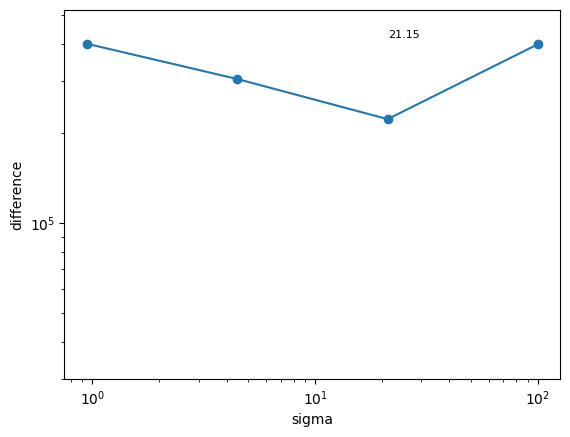

In [16]:
print(np.array(outputs).shape)

diff = np.diff(np.array(outputs),axis=0)
avg_diff = np.sum(np.abs(diff), axis=(1,2))

# print(sigmas,avg_diff)

fig, ax = plt.subplots()

line, = ax.plot(sigmas[1:],avg_diff, '-o')

arrowprops = dict(
    arrowstyle="->")

for i in range(0,len(avg_diff),3):
    ax.annotate(np.around(sigmas[i],2), xy=(sigmas[i],avg_diff[i]), 
    xytext=(sigmas[i],avg_diff[i]+20000),fontsize=8)

plt.ylim(30000,520000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('sigma')
plt.ylabel('difference')
# plt.title('difference per pixel')

plt.show()

In [17]:
print(min(avg_diff),max(avg_diff))

223149.72 399177.56


### STFT.

### Plots for STFT and FCWT

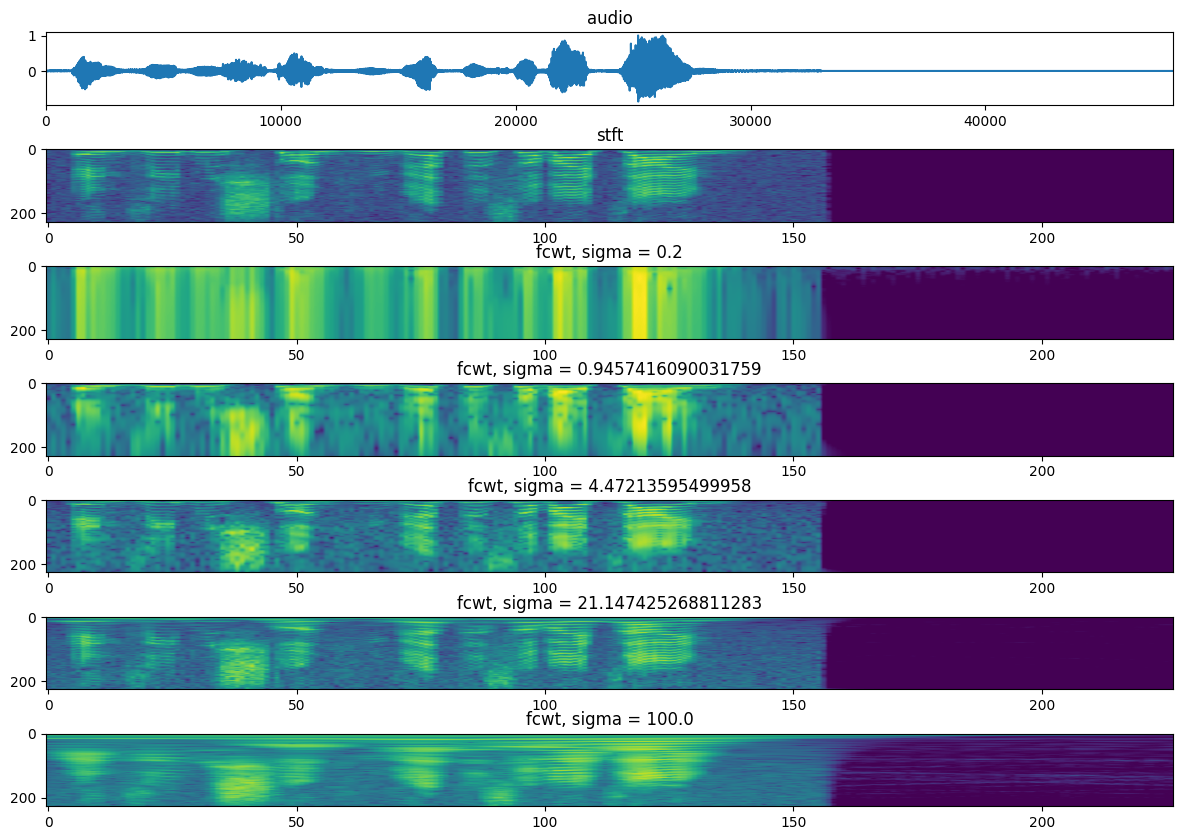

In [18]:
# hop = (sl*Fs)//size[0]

stft = librosa.stft(y=signal, n_fft=455, win_length=455, hop_length=211)
filtered_stft = stft[0:227, 0:227]
stft_db = librosa.amplitude_to_db(np.abs(filtered_stft), ref=np.max)

fig, axs = plt.subplots(len(outputs)+2, figsize=(12, len(sigmas)*10/6))
fig.tight_layout()

axs[0].plot(signal)
axs[0].set_xbound(0,48000)
axs[0].set_title('audio')

axs[1].imshow(stft_db, aspect = 'auto')
axs[1].set_title('stft')

for i in range(len(outputs)):
    sigma = sigmas[i]
    axs[i+2].imshow(outputs[i], aspect='auto')
    axs[i+2].set_title('fcwt, sigma = %s' % sigma)


### Comparison of delta features

In [19]:
stft_image = TF.generate_stft_image(signal,out_size = size[0],signal_len=sl,Fs=Fs,n_fft=455, win_length = 455,hop_length = 211, toint = True)

stft0 = stft_image[:, :, 0]
stft1 = stft_image[:, :, 1]
stft2 = stft_image[:, :, 2]

sigma = 1
fcwt_image = TF.generate_fcwt_image(np.array(signal, dtype = 'float32'), 227, 16000, 1, 7982, 7982, sigma, False) # CHECK PARAMS

fcwt0 = fcwt_image[:, :, 0]
fcwt1 = fcwt_image[:, :, 1]
fcwt2 = fcwt_image[:, :, 2]
